# Export across the 1000-m isobath in MOM6

In [1]:
%matplotlib inline
import xarray as xr
import numpy as np
import cosima_cookbook as cc
from dask.distributed import Client

import matplotlib.pyplot as plt
import cmocean.cm as cmo

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/41019/status,
Dashboard: /proxy/41019/status,Workers: 8
Total threads: 48,Total memory: 180.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44111,Workers: 8
Dashboard: /proxy/41019/status,Total threads: 48
Started: Just now,Total memory: 180.00 GiB
Comm: tcp://127.0.0.1:41277,Total threads: 6
Dashboard: /proxy/37695/status,Memory: 22.50 GiB
Nanny: tcp://127.0.0.1:34283,


## Load data

In [ ]:
# USE THIS CELL IF EXPERIMENT IS ALREADY IN DATABASE
session = cc.database.create_session()
expt = 'panant-01-zstar-v13'

frequency = '1 monthly'
path_output = '/g/data/e14/cs6673/mom6_comparison/data_DSW/'

In [3]:
# USE THIS CELL IF EXPERIMENT IS NOT IN DATABASE
expt = 'panan_005deg_jra55_ryf'
db = expt + '.db'

session = cc.database.create_session(db)

# create database
directory_list = ['/scratch/e14/cs6673/mom6/archive/' + expt + '/']
cc.database.build_index(directory_list, session)


frequency = '1 monthly'
path_output = '/g/data/e14/cs6673/mom6_comparison/data_DSW/'

Indexing experiment: panan_005deg_jra55_ryf


100%|██████████| 34/34 [00:06<00:00,  5.54it/s]


In [87]:
year = '1997'

start_time= year + '-01-01'
end_time= year + '-12-31'

# reference density in MOM6 
rho_0 = 1035.0
# Note: change this range, so it matches the size of your contour arrays
if expt == 'panan_005deg_jra55_ryf':
    lat_range = slice(-78, -59)
else:
    lat_range = slice(-90, -59)

In [88]:
DSW_region = {
    'name': ['Weddell', 'Prydz', 'Adelie', 'Ross'],
    'name_long': ['Weddell Sea', 'Prydz Bay', 'Adélie Coast', 'Ross Sea'],
    'lon': [[-60, -35, -48, -62, -60],
            [48, 73, 74, 48, 48],
            [128-360, 152-360, 152-360, 128-360, 128-360],
            [185-360, 160-360, 164-360, 172-360, 185-360]],
    'lat': [[-71, -75, -78, -75, -71],
            [-65, -66.5, -69, -68, -65],
            [-64.5, -66, -69, -67.5, -64.5],
            [-78, -78, -73, -71.5, -78]],
    'ind_iso_min': [3647, 5151, 581, 1141],
    'ind_iso_max': [4307, 134, 960, 1830]}

### Open grid cell with data for domain

In [89]:
# some grid data is required, a little complicated because these
# variables don't behave well with some 
dyt = cc.querying.getvar(expt, 'dyt', session, n=1)
dxu = cc.querying.getvar(expt, 'dxCu', session, n=1)
dxv = cc.querying.getvar(expt, 'dxCv', session, n=1)

# select latitude range:
dyt = dyt.sel(yh=lat_range)
dxu = dxu.sel(yh=lat_range)
dxv = dxv.sel(yq=lat_range)

### Open contour data

In [90]:
if expt == 'panan_005deg_jra55_ryf':
    data = xr.open_dataset(
        '/home/142/cs6673/work/mom6_comparison/Python_scripts/' +
        'Antarctic_slope_contour_1000m_MOM6_005deg.nc')
else:
    isobath_depth = 1000
    outfile = ('/g/data/v45/akm157/model_data/access-om2/Antarctic_slope_contour_' +
               str(isobath_depth) + 'm.npz')
    data = np.load(outfile)

mask_y_transport = data['mask_y_transport'].data
mask_x_transport = data['mask_x_transport'].data
mask_y_transport_numbered = data['mask_y_transport_numbered'].data
mask_x_transport_numbered = data['mask_x_transport_numbered'].data

yh = cc.querying.getvar(expt, 'yh', session, n=1)
yh = yh.sel(yh=lat_range)
yq = cc.querying.getvar(expt, 'yq', session, n=1)
yq = yq.sel(yq=lat_range)
if expt != 'panan_005deg_jra55_ryf':
    yq = yq[1:]
xh = cc.querying.getvar(expt, 'xh', session, n=1)
xq = cc.querying.getvar(expt, 'xq', session, n=1)[1:]

# Convert contour masks to data arrays, so we can multiply them later.
# We need to ensure the lat lon coordinates correspond to the actual data location:
#       The y masks are used for vmo, so like vmo this should have dimensions (yq, xh).
#       The x masks are used for umo, so like umo this should have dimensions (yh, xq).
#       However the actual name will always be simply y or x irrespective of the variable
#       to make concatenation of transports in both direction and sorting possible.

mask_x_transport = xr.DataArray(
    mask_x_transport, coords=[('y', yh.data), ('x', xq.data)])
mask_y_transport = xr.DataArray(
    mask_y_transport, coords=[('y', yq.data), ('x', xh.data)])
mask_x_transport_numbered = xr.DataArray(
    mask_x_transport_numbered, coords=[('y', yh.data), ('x', xq.data)])
mask_y_transport_numbered = xr.DataArray(
    mask_y_transport_numbered, coords=[('y', yq.data), ('x', xh.data)])

# number of points along contour:
num_points = int(np.maximum(
    np.max(mask_y_transport_numbered),np.max(mask_x_transport_numbered)))

### Stack contour data into 1D and extract lat/lon on contour

In [91]:
# Create the contour order data-array. Note that in this procedure the x-grid counts have x-grid
#   dimensions and the y-grid counts have y-grid dimensions, but these are implicit, the dimension 
#   *names* are kept general across the counts, the generic y/x, so that concatening works
#   but we dont double up with numerous counts for one lat/lon point.

# stack contour data into 1d:
mask_x_numbered_1d = mask_x_transport_numbered.stack(contour_index = ['y', 'x'])
mask_x_numbered_1d = mask_x_numbered_1d.where(mask_x_numbered_1d > 0, drop = True)
mask_y_numbered_1d = mask_y_transport_numbered.stack(contour_index = ['y', 'x'])
mask_y_numbered_1d = mask_y_numbered_1d.where(mask_y_numbered_1d > 0, drop = True)
contour_ordering = xr.concat((mask_x_numbered_1d,mask_y_numbered_1d), dim = 'contour_index')
contour_ordering = contour_ordering.sortby(contour_ordering)

# get lat and lon along contour, useful for plotting later:
lat_along_contour = contour_ordering.y
lon_along_contour = contour_ordering.x
contour_index_array = np.arange(1,len(contour_ordering)+1)
# don't need the multi-index anymore, replace with contour count and save
lat_along_contour = lat_along_contour.drop_vars({'x', 'y', 'contour_index'})
lat_along_contour.coords['contour_index'] = contour_index_array
lon_along_contour = lon_along_contour.drop_vars({'x', 'y', 'contour_index'})
lon_along_contour.coords['contour_index'] = contour_index_array

### Load mass transport umo and vmo

In [92]:
vmo = cc.querying.getvar(
    expt, 'vmo', session, frequency=frequency,
    start_time=start_time, end_time=end_time,
    chunks={'xh': '200MB', 'yq': '200MB'})
umo = cc.querying.getvar(
    expt, 'umo', session, frequency=frequency,
    start_time=start_time, end_time=end_time,
    chunks={'xq': '200MB', 'yh': '200MB'})

# select latitude range and this year:
vmo = vmo.sel(yq=lat_range).sel(time=slice(start_time,end_time))
vmo = vmo.isel(yq=slice(1, None))
umo = umo.sel(yh=lat_range).sel(time=slice(start_time,end_time))
umo = umo.isel(xq=slice(1, None))


# Note that vmo is Ocean Mass Y Transport (kg s-1) and defined as the transport across
# the northern edge of a tracer cell so its coordinates should be (yq, xh).
# umo is Ocean Mass X Transport (kg s-1) and defined as the transport across
# the eastern edge of a tracer cell so its coordinates should be (yh, xq).
# However we will keep the actual name as simply y/x irrespective of the variable
# to make concatenation and sorting possible.
vmo = vmo.rename({'yq':'y', 'xh':'x'})
umo = umo.rename({'yh':'y', 'xq':'x'})

# convert kg/s to Sv and multiply by contour masks
vmo = vmo/(1e6*rho_0)*mask_y_transport
umo = umo/(1e6*rho_0)*mask_x_transport

### Extract transport values along contour

In [93]:
umo_i = umo.compute()
vmo_i = vmo.compute()

# stack transports into 1d and drop any points not on contour:
x_transport_1d_i = umo_i.stack(contour_index=['y', 'x'])
x_transport_1d_i = x_transport_1d_i.where(mask_x_numbered_1d>0, drop=True)
y_transport_1d_i = vmo_i.stack(contour_index=['y', 'x'])
y_transport_1d_i = y_transport_1d_i.where(mask_y_numbered_1d>0, drop=True)

# combine all points on contour:
vol_trans_across_contour = xr.concat(
    (x_transport_1d_i, y_transport_1d_i), dim='contour_index')
vol_trans_across_contour = vol_trans_across_contour.sortby(contour_ordering)
vol_trans_across_contour = vol_trans_across_contour.drop_vars(
    {'x', 'contour_index', 'y'})
vol_trans_across_contour.coords['contour_index'] = contour_index_array
vol_trans_across_contour = vol_trans_across_contour.compute()

### Save data

In [94]:
vol_trans_across_contour.name = 'vol_trans_across_contour'
vol_trans_across_contour.attrs = {
    'long_name': 'Volume transport across 1000-m isobath',
    'units': 'Sv'}
ds = vol_trans_across_contour.to_dataset()
ds['lat'] = lat_along_contour
ds['lon'] = lon_along_contour
enc = {'vol_trans_across_contour':
       {'chunksizes': (12, 79, 6002),
        'zlib': True, 'complevel': 5, 'shuffle': True}}
ds.to_netcdf(
    path_output + 'vol_transp_across_contour_' + expt + '_' +
    frequency[:3:2] + '_' + year + '.nc', encoding=enc)

## Plots

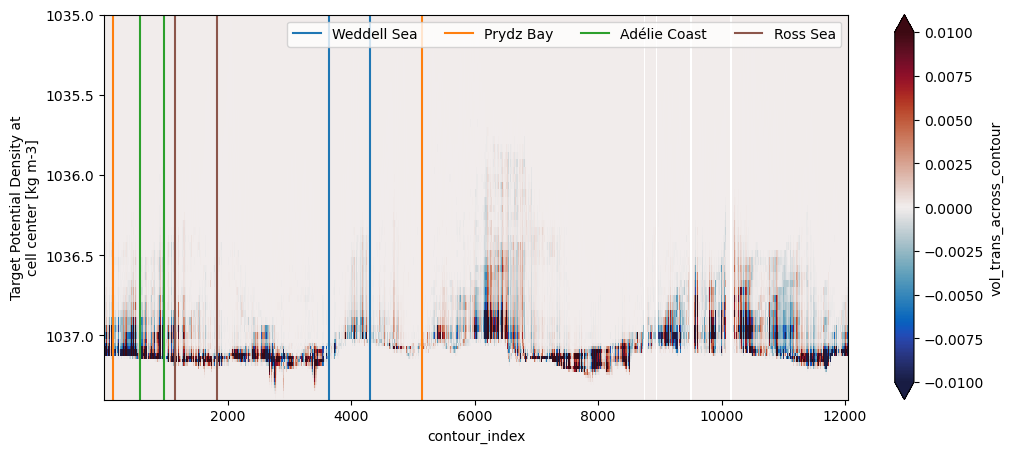

In [95]:
plt.figure(figsize=(12, 5))
vol_trans_across_contour.mean('time').plot(vmin=-.01, vmax=.01, cmap=cmo.balance)
plt.ylim(1037.4, 1035)

if expt != 'panan_005deg_jra55_ryf':
    col = ['tab:blue', 'tab:orange', 'tab:green', 'tab:brown']
    for a, area_text in enumerate(DSW_region['name']):
        plt.axvline(vol_trans_across_contour.contour_index[DSW_region['ind_iso_min'][a]],
                    color=col[a], label=DSW_region['name_long'][a])
        plt.axvline(vol_trans_across_contour.contour_index[DSW_region['ind_iso_max'][a]],
                    color=col[a])

plt.legend(ncol=4)  
plt.show()

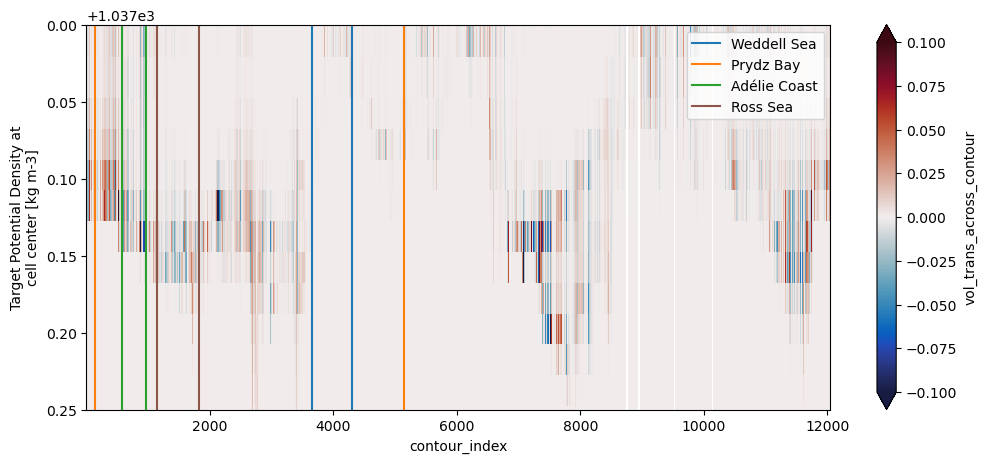

In [96]:
plt.figure(figsize=(12, 5))
vol_trans_across_contour.mean('time').plot(vmin=-.1, vmax=.1, cmap=cmo.balance)
plt.ylim(1037.25, 1037.0)

if expt != 'panan_005deg_jra55_ryf':
    col = ['tab:blue', 'tab:orange', 'tab:green', 'tab:brown']
    for a, area_text in enumerate(DSW_region['name']):
        plt.axvline(vol_trans_across_contour.contour_index[DSW_region['ind_iso_min'][a]],
                    color=col[a], label=DSW_region['name_long'][a])
        plt.axvline(vol_trans_across_contour.contour_index[DSW_region['ind_iso_max'][a]],
                    color=col[a])

plt.legend()  
plt.show()

### Circumpolar offshore transport across 1000-m isobath

In [97]:
""" Sum over all density bins above a certain density and
calculate the cumulative sum along the isobaths. Take time mean for plotting."""
transp1000m_37_0 = vol_trans_across_contour.sel(rho2_l=slice(1037, None)).sum(
    'rho2_l').cumsum('contour_index').mean('time').compute()
transp1000m_37_1 = vol_trans_across_contour.sel(rho2_l=slice(1037.1, None)).sum(
    'rho2_l').cumsum('contour_index').mean('time').compute()
transp1000m_37_15 = vol_trans_across_contour.sel(rho2_l=slice(1037.15, None)).sum(
    'rho2_l').cumsum('contour_index').mean('time').compute()
transp1000m_37_17 = vol_trans_across_contour.sel(rho2_l=slice(1037.17, None)).sum(
    'rho2_l').cumsum('contour_index').mean('time').compute()

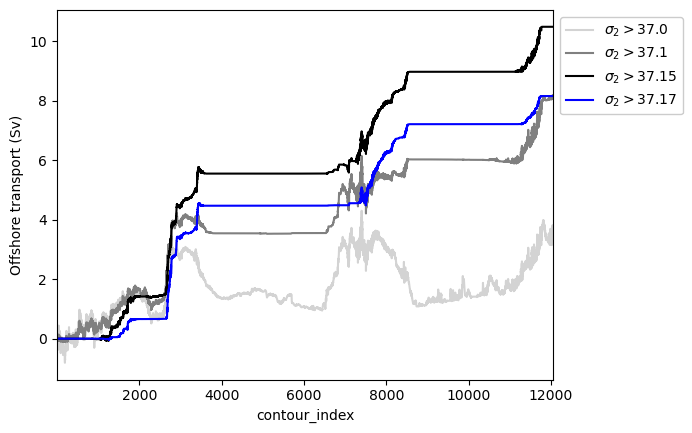

In [98]:
transp1000m_37_0.plot(
    color='lightgrey', label='$\sigma_2>37.0$')
transp1000m_37_1.plot(
    color='grey', label='$\sigma_2>37.1$')
transp1000m_37_15.plot(
    color='k', label='$\sigma_2>37.15$')
transp1000m_37_17.plot(
    color='b', label='$\sigma_2>37.17$')

if expt != 'panan_005deg_jra55_ryf':
    col = ['tab:blue', 'tab:orange', 'tab:green', 'tab:brown']
    for a, area_text in enumerate(DSW_region['name']):
        if area_text == 'Prydz':
            plt.axvspan(0, transp1000m_37_0.contour_index[DSW_region['ind_iso_max'][a]],
                        alpha=0.5, color=col[a], label=DSW_region['name_long'][a])
            plt.axvspan(transp1000m_37_0.contour_index[DSW_region['ind_iso_min'][a]], 6002,
                        alpha=0.5, color=col[a])
        else:
            plt.axvspan(transp1000m_37_0.contour_index[DSW_region['ind_iso_min'][a]],
                transp1000m_37_0.contour_index[DSW_region['ind_iso_max'][a]],
                alpha=0.5, color=col[a], label=DSW_region['name_long'][a])

plt.autoscale(enable=True, axis='x', tight=True)
plt.legend(framealpha=1, loc='upper left', bbox_to_anchor=(1, 1))
plt.ylabel('Offshore transport (Sv)')
# plt.ylim(-1.6, 10)
plt.show()